# Global Flights Forecasting Notebook

Notebook end-to-end para consolidar datos de plantas operativas, realizar EDA, entrenar modelos de forecasting e identificar el Indice de Demanda Diaria (IDD).

## 1. Configuracion y Consolidacion de Datos

In [1]:
import json
import os
import re
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from IPython.display import display
from sklearn.metrics import mean_absolute_percentage_error

sns.set_theme(style="whitegrid", palette="tab10")
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12
np.random.seed(42)

search_roots = [
    Path("..").resolve() / "data",
    Path("..").resolve() / "Gategroup 2025",
]
search_roots.extend(sorted(Path("..").resolve().glob("Gategroup 2025*/Gategroup 2025")))

csv_paths = []
for root in search_roots:
    if root.exists():
        csv_paths.extend(sorted(root.glob("Plant*.csv")))

if not csv_paths:
    raise FileNotFoundError("No se encontraron archivos 'Plant*.csv' en las rutas esperadas.")

frames = []
for path in csv_paths:
    match = re.search(r"Plant\s*([0-9]+)", path.stem)
    if not match:
        raise ValueError(f"No se pudo extraer el plant_id desde el nombre {path.name}")
    plant_id = int(match.group(1))
    df_temp = pd.read_csv(path, encoding="utf-8-sig", low_memory=False)
    df_temp["plant_id"] = plant_id
    frames.append(df_temp)

df_consolidated = pd.concat(frames, ignore_index=True)
df_consolidated.columns = [col.strip().lower().replace(" ", "_") for col in df_consolidated.columns]

if "day" not in df_consolidated.columns:
    raise KeyError("La columna 'day' es obligatoria.")

day_raw = df_consolidated["day"].copy()
df_consolidated["day"] = pd.to_datetime(day_raw, errors="coerce")
mask_missing = df_consolidated["day"].isna() & day_raw.notna()
if mask_missing.any():
    df_consolidated.loc[mask_missing, "day"] = pd.to_datetime(
        day_raw[mask_missing].astype(str), format="%Y%m%d", errors="coerce"
    )

for column in ["flights", "passengers", "max_capacity"]:
    if column in df_consolidated.columns:
        df_consolidated[column] = pd.to_numeric(df_consolidated[column], errors="coerce")

df_consolidated["plant_id"] = pd.to_numeric(df_consolidated["plant_id"], errors="coerce").astype("Int64")
df_consolidated = df_consolidated.set_index("day").sort_index()

df_consolidated.info()
display(df_consolidated.head())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1818 entries, 2023-01-02 to 2025-08-31
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   flights       1818 non-null   int64  
 1   passengers    845 non-null    float64
 2   max_capacity  845 non-null    float64
 3   plant_id      1818 non-null   Int64  
dtypes: Int64(1), float64(2), int64(1)
memory usage: 72.8 KB


,flights,passengers,max_capacity,plant_id
day,,,,
2023-01-02,352,94434.0,99351.0,1
2023-01-02,19,NaN,NaN,2
2023-01-03,23,NaN,NaN,2
2023-01-03,356,92710.0,99616.0,1
2023-01-04,358,88888.0,99437.0,1


## 2. Analisis Exploratorio de Datos (EDA) Comparativo

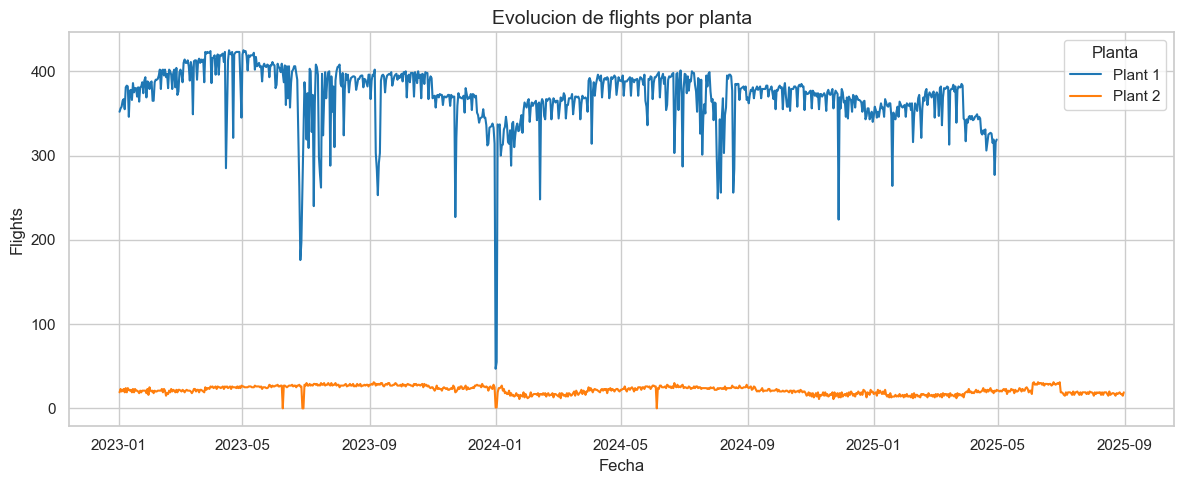

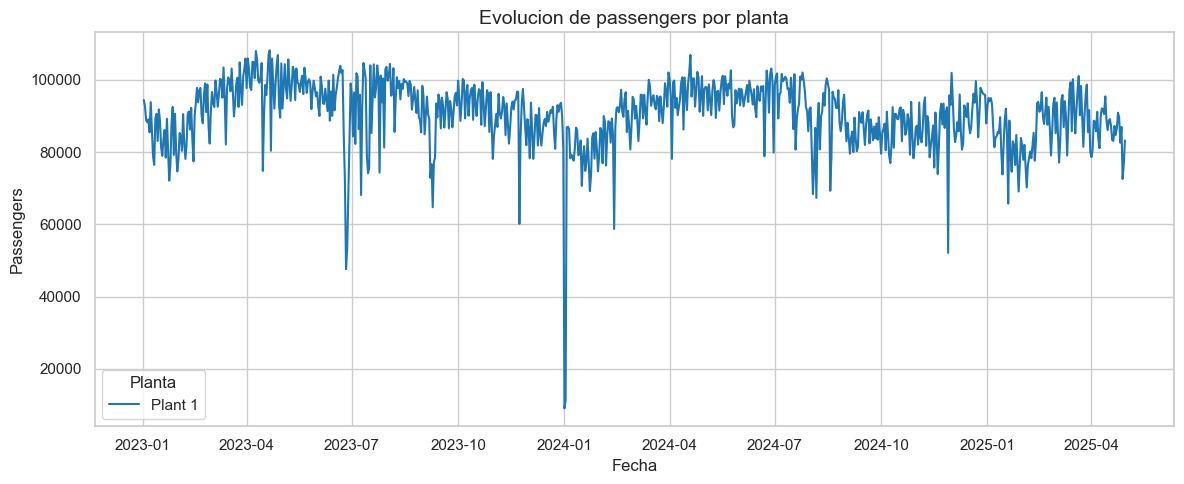

In [2]:
if df_consolidated.empty:
    print("El DataFrame consolidado esta vacio; no se generan graficos.")
else:
    if "flights" in df_consolidated.columns:
        fig, ax = plt.subplots()
        for plant_id, group in df_consolidated.groupby("plant_id"):
            ax.plot(group.index, group["flights"], label=f"Plant {plant_id}")
        ax.set_title("Evolucion de flights por planta")
        ax.set_xlabel("Fecha")
        ax.set_ylabel("Flights")
        ax.legend(title="Planta")
        plt.tight_layout()
        plt.show()
    else:
        print("La columna 'flights' no esta disponible para graficar.")

    if "passengers" in df_consolidated.columns and df_consolidated["passengers"].notna().any():
        fig, ax = plt.subplots()
        subset = df_consolidated[df_consolidated["passengers"].notna()]
        for plant_id, group in subset.groupby("plant_id"):
            ax.plot(group.index, group["passengers"], label=f"Plant {plant_id}")
        ax.set_title("Evolucion de passengers por planta")
        ax.set_xlabel("Fecha")
        ax.set_ylabel("Passengers")
        ax.legend(title="Planta")
        plt.tight_layout()
        plt.show()
    else:
        print("No hay datos de passengers disponibles para graficar.")


## 3. Creacion de Variables (Feature Engineering)

In [3]:
def create_features(df: pd.DataFrame) -> pd.DataFrame:
    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError("El indice debe ser un DatetimeIndex.")
    featured = df.copy()
    iso_calendar = featured.index.isocalendar()
    featured["dayofweek"] = featured.index.dayofweek
    featured["quarter"] = featured.index.quarter
    featured["month"] = featured.index.month
    featured["year"] = featured.index.year
    featured["dayofyear"] = featured.index.dayofyear
    featured["weekofyear"] = iso_calendar.week.astype(int)
    return featured

df_featured = create_features(df_consolidated)
display(df_featured.head())


,flights,passengers,max_capacity,plant_id,dayofweek,quarter,month,year,dayofyear,weekofyear
day,,,,,,,,,,
2023-01-02,352,94434.0,99351.0,1,0,1,1,2023,2,1
2023-01-02,19,NaN,NaN,2,0,1,1,2023,2,1
2023-01-03,23,NaN,NaN,2,1,1,1,2023,3,1
2023-01-03,356,92710.0,99616.0,1,1,1,1,2023,3,1
2023-01-04,358,88888.0,99437.0,1,2,1,1,2023,4,1


## 4. Modelo de vuelos (XGBoost)

In [4]:
TARGET_FLIGHTS = "flights"
FEATURES = ["plant_id", "dayofweek", "quarter", "month", "year", "dayofyear", "weekofyear"]

if df_featured.empty:
    raise ValueError("No hay datos disponibles para entrenamiento.")

missing_columns = [col for col in FEATURES + [TARGET_FLIGHTS] if col not in df_featured.columns]
if missing_columns:
    raise KeyError(f"Faltan columnas requeridas: {missing_columns}")

df_model_flights = df_featured[FEATURES + [TARGET_FLIGHTS]].dropna().copy()
if df_model_flights.empty:
    raise ValueError("No quedan observaciones tras eliminar valores nulos.")

df_model_flights["plant_id"] = df_model_flights["plant_id"].astype(int)

last_date_flights = df_model_flights.index.max()
cutoff_test_flights = last_date_flights - pd.DateOffset(months=3)

train_flights = df_model_flights.loc[df_model_flights.index <= cutoff_test_flights]
test_flights = df_model_flights.loc[df_model_flights.index > cutoff_test_flights]

if train_flights.empty or test_flights.empty:
    raise ValueError("La division temporal no genero suficientes datos para train y test.")

baseline_flights = train_flights.groupby("plant_id")[TARGET_FLIGHTS].mean()

val_cut_flights = train_flights.index.max() - pd.DateOffset(months=1)
train_fit_flights = train_flights.loc[train_flights.index <= val_cut_flights]
val_flights = train_flights.loc[train_flights.index > val_cut_flights]

if train_fit_flights.empty or val_flights.empty:
    raise ValueError("No hay suficientes datos para crear una validacion temporal.")

X_fit_flights = train_fit_flights[FEATURES]
y_fit_flights = train_fit_flights[TARGET_FLIGHTS]
X_val_flights = val_flights[FEATURES]
y_val_flights = val_flights[TARGET_FLIGHTS]

X_test_flights = test_flights[FEATURES]
y_test_flights = test_flights[TARGET_FLIGHTS]

reg_flights = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    early_stopping_rounds=50,
    random_state=42,
    n_jobs=-1,
    tree_method="hist",
    eval_metric="rmse",
)

reg_flights.fit(X_fit_flights, y_fit_flights, eval_set=[(X_val_flights, y_val_flights)], verbose=False)
print(f"Entrenamiento de vuelos completado. Mejor iteracion: {reg_flights.best_iteration}")


Entrenamiento de vuelos completado. Mejor iteracion: 766


## 5. Evaluacion e IDD de vuelos

MAPE de vuelos en el conjunto de prueba: 25.90%


,plant_id,y_true_flights,y_pred_flights,baseline_flights,idd_flights,recommended_staff_base_50
day,,,,,,
2025-06-01,2,21,22.449268,21.775255,1.030953,52
2025-06-02,2,21,23.031023,21.775255,1.057669,53
2025-06-03,2,17,22.561605,21.775255,1.036112,52
2025-06-04,2,30,22.510803,21.775255,1.033779,52
2025-06-05,2,31,21.726967,21.775255,0.997782,50


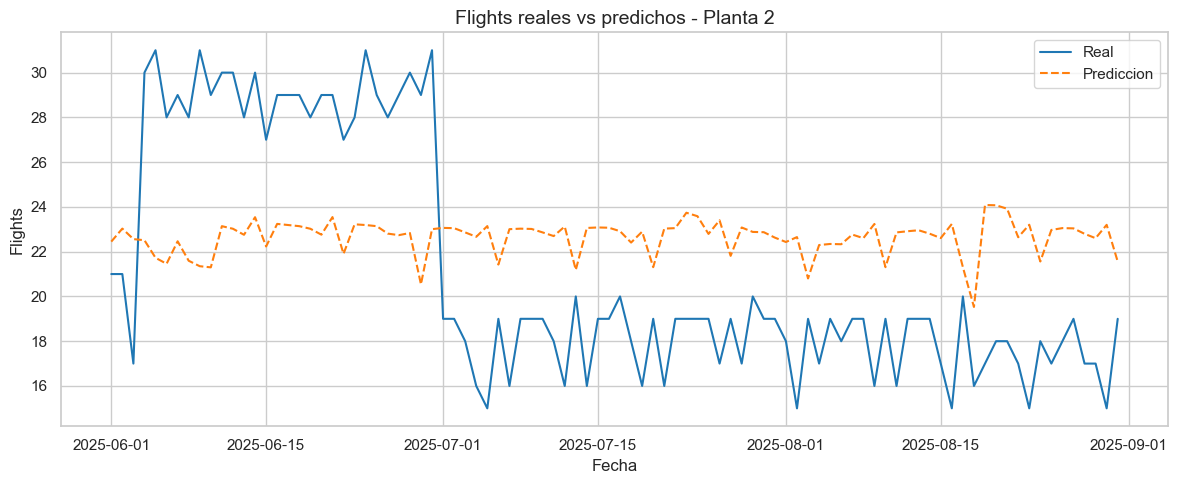

In [5]:
y_pred_flights = reg_flights.predict(X_test_flights)
zero_mask_flights = y_test_flights == 0
if zero_mask_flights.any():
    valid_mask = ~zero_mask_flights
    print(f"Se excluyeron {zero_mask_flights.sum()} observaciones con valor real 0 para calcular el MAPE.")
    mape_flights = mean_absolute_percentage_error(y_test_flights[valid_mask], y_pred_flights[valid_mask])
else:
    mape_flights = mean_absolute_percentage_error(y_test_flights, y_pred_flights)

print(f"MAPE de vuelos en el conjunto de prueba: {mape_flights * 100:.2f}%")

baseline_lookup_flights = baseline_flights.reindex(X_test_flights["plant_id"]).to_numpy()
idd_flights = np.divide(
    y_pred_flights,
    baseline_lookup_flights,
    out=np.full_like(y_pred_flights, np.nan, dtype=float),
    where=baseline_lookup_flights > 0,
)

df_flight_results = pd.DataFrame(
    {
        "plant_id": X_test_flights["plant_id"].to_numpy(),
        "y_true_flights": y_test_flights.to_numpy(),
        "y_pred_flights": y_pred_flights,
        "baseline_flights": baseline_lookup_flights,
        "idd_flights": idd_flights,
    },
    index=X_test_flights.index,
)
df_flight_results["recommended_staff_base_50"] = np.ceil(df_flight_results["idd_flights"] * 50).astype("Int64")

display(df_flight_results.head())

for plant_id, group in df_flight_results.groupby("plant_id"):
    fig, ax = plt.subplots()
    ax.plot(group.index, group["y_true_flights"], label="Real", linestyle="-")
    ax.plot(group.index, group["y_pred_flights"], label="Prediccion", linestyle="--")
    ax.set_title(f"Flights reales vs predichos - Planta {plant_id}")
    ax.set_xlabel("Fecha")
    ax.set_ylabel("Flights")
    ax.legend()
    plt.tight_layout()
    plt.show()


## 6. Modelo de pasajeros (IDD de demanda)

In [6]:
TARGET_PASSENGERS = "passengers"
passenger_columns = FEATURES + [TARGET_PASSENGERS]
available_passengers = [col for col in passenger_columns if col in df_featured.columns]

passenger_model = None
df_passenger_results = pd.DataFrame()
baseline_passengers = pd.Series(dtype=float)

if TARGET_PASSENGERS not in df_featured.columns:
    print("La columna 'passengers' no esta disponible en el DataFrame.")
else:
    df_model_passengers = df_featured[passenger_columns].dropna().copy()
    if df_model_passengers.empty:
        print("No hay suficientes datos de pasajeros para entrenar un modelo.")
    else:
        df_model_passengers["plant_id"] = df_model_passengers["plant_id"].astype(int)

        last_date_passengers = df_model_passengers.index.max()
        cutoff_test_passengers = last_date_passengers - pd.DateOffset(months=3)

        train_passengers = df_model_passengers.loc[df_model_passengers.index <= cutoff_test_passengers]
        test_passengers = df_model_passengers.loc[df_model_passengers.index > cutoff_test_passengers]

        if train_passengers.empty or test_passengers.empty:
            print("No hay suficiente cobertura temporal para dividir datos de pasajeros.")
        else:
            baseline_passengers = train_passengers.groupby("plant_id")[TARGET_PASSENGERS].mean()

            val_cut_passengers = train_passengers.index.max() - pd.DateOffset(months=1)
            train_fit_passengers = train_passengers.loc[train_passengers.index <= val_cut_passengers]
            val_passengers = train_passengers.loc[train_passengers.index > val_cut_passengers]

            if train_fit_passengers.empty or val_passengers.empty:
                print("No hay suficientes datos de pasajeros para crear una validacion temporal.")
            else:
                X_fit_passengers = train_fit_passengers[FEATURES]
                y_fit_passengers = train_fit_passengers[TARGET_PASSENGERS]
                X_val_passengers = val_passengers[FEATURES]
                y_val_passengers = val_passengers[TARGET_PASSENGERS]

                X_test_passengers = test_passengers[FEATURES]
                y_test_passengers = test_passengers[TARGET_PASSENGERS]

                passenger_model = xgb.XGBRegressor(
                    n_estimators=800,
                    learning_rate=0.02,
                    early_stopping_rounds=50,
                    random_state=42,
                    n_jobs=-1,
                    tree_method="hist",
                    eval_metric="rmse",
                )

                passenger_model.fit(
                    X_fit_passengers,
                    y_fit_passengers,
                    eval_set=[(X_val_passengers, y_val_passengers)],
                    verbose=False,
                )
                print(f"Entrenamiento de pasajeros completado. Mejor iteracion: {passenger_model.best_iteration}")

                y_pred_passengers = passenger_model.predict(X_test_passengers)
                zero_mask_passengers = y_test_passengers == 0
                if zero_mask_passengers.any():
                    valid_mask_pass = ~zero_mask_passengers
                    print(
                        f"Se excluyeron {zero_mask_passengers.sum()} observaciones con valor real 0 de pasajeros para calcular el MAPE."
                    )
                    mape_passengers = mean_absolute_percentage_error(
                        y_test_passengers[valid_mask_pass], y_pred_passengers[valid_mask_pass]
                    )
                else:
                    mape_passengers = mean_absolute_percentage_error(y_test_passengers, y_pred_passengers)

                print(f"MAPE de pasajeros en el conjunto de prueba: {mape_passengers * 100:.2f}%")

                baseline_lookup_passengers = baseline_passengers.reindex(
                    X_test_passengers["plant_id"]
                ).to_numpy()
                idd_passengers = np.divide(
                    y_pred_passengers,
                    baseline_lookup_passengers,
                    out=np.full_like(y_pred_passengers, np.nan, dtype=float),
                    where=baseline_lookup_passengers > 0,
                )

                df_passenger_results = pd.DataFrame(
                    {
                        "plant_id": X_test_passengers["plant_id"].to_numpy(),
                        "y_true_passengers": y_test_passengers.to_numpy(),
                        "y_pred_passengers": y_pred_passengers,
                        "baseline_passengers": baseline_lookup_passengers,
                        "idd_passengers": idd_passengers,
                    },
                    index=X_test_passengers.index,
                )

                display(df_passenger_results.head())


Entrenamiento de pasajeros completado. Mejor iteracion: 12
MAPE de pasajeros en el conjunto de prueba: 7.12%


,plant_id,y_true_passengers,y_pred_passengers,baseline_passengers,idd_passengers
day,,,,,
2025-01-31,1,82044.0,89564.812500,90879.64106,0.985532
2025-02-01,1,77895.0,88870.523438,90879.64106,0.977893
2025-02-02,1,82031.0,88870.523438,90879.64106,0.977893
2025-02-03,1,76007.0,89398.570312,90879.64106,0.983703
2025-02-04,1,70224.0,87774.226562,90879.64106,0.965829


## 7. Guardado de artefactos e IDD

In [7]:
artifacts_dir = Path("..").resolve() / "backend" / "models"
artifacts_dir.mkdir(parents=True, exist_ok=True)

artifact_path = artifacts_dir / "global_flights_forecasting_model.pkl"
idd_path = artifacts_dir / "latest_idd.csv"

artifacts_payload = {
    "flights_model": reg_flights,
    "flight_features": FEATURES,
    "flight_baseline": baseline_flights.to_dict(),
    "passenger_model": passenger_model,
    "passenger_features": FEATURES if passenger_model is not None else None,
    "passenger_baseline": baseline_passengers.to_dict() if not baseline_passengers.empty else {},
}

joblib.dump(artifacts_payload, artifact_path)

idd_export = df_flight_results.copy()
if not df_passenger_results.empty:
    idd_export = idd_export.join(
        df_passenger_results.rename(columns={"plant_id": "plant_id_passengers"}),
        how="outer",
    )
    if "plant_id_passengers" in idd_export.columns:
        idd_export["plant_id"] = idd_export["plant_id"].fillna(idd_export.pop("plant_id_passengers"))

idd_export = idd_export.reset_index().rename(columns={"index": "date"})
idd_export.to_csv(idd_path, index=False)

print(f"Modelo y metadatos guardados en: {artifact_path.resolve()}")
print(f"IDD consolidado guardado en: {idd_path.resolve()}")


Modelo y metadatos guardados en: C:\Users\Lenovo\Desktop\UdeCodes\backend\models\global_flights_forecasting_model.pkl
IDD consolidado guardado en: C:\Users\Lenovo\Desktop\UdeCodes\backend\models\latest_idd.csv
